# p_tqdm

### The combined power of parallel processing and cute progress bars for anxious girlies

The creator is Kyle Swanson, a PhD student in Computer Science at Stanford University.

**p_tqdm makes parallel processing with progress bars easy**

Have you ever found yourself in a situation in which you have no idea how long your Python script will take to finish running? (will this take minutes... hours...? _it's giving anxiety_)

Instead of print(i) (_not mindful, not demure_) you can use a progress bar while your code is paralellized (_very cutesy, very demure_)

From the official [github page](https://github.com/swansonk14):

- p_tqdm is a wrapper around pathos.multiprocessing and tqdm. 
- Unlike Python's default multiprocessing library, pathos provides a more flexible parallel map which can apply almost any type of function, including lambda functions, nested functions, and class methods, and can easily handle functions with multiple arguments. 
- tqdm is applied on top of pathos's parallel map and displays a progress bar including an estimated time to completion.

**I find it especially useful when I am studying ranges of parameter values for my numerical model (which is basically all the time) to test my parameter choices before going all in in a cluster.**

In this quick demo I will use the Rosenzweig-Macarthur predator-prey model to demonstrate how p_tqdm package can be used when studying the effect of changing prey carrying capacity (K) on the population abundances. For that we will make a bifurcation diagram.


In [8]:
# First load the packages we will use to solve the ODE and plot the results
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# we will also use the time package to time how long it takes to solve the ODE
from timeit import default_timer as timer

In [2]:
# create a function for your model according to odeint() format
def RM(y, t, r, K, a, h, e, d):
    return np.array([y[0]*(r*(1-y[0]/K) - a*y[1]/(1+a*h*y[0])),
                   y[1]*(e*a*y[0]/(1+a*h*y[0]) - d)])

**What you could do without p_tqdm package**

To study the effect of changing K you could loop over the values and use print(i) to keep track of the progress.

However this get messy as the values of K you want to study increases.

Also, you are underusing the processing power of your computer as you do one simmulation at a time in a sequential way.

In [13]:
# start the time stamp for the process
start = timer()

y = [1, 1.] # define initial population abundances / state variables
time = np.arange(0, 6000, 1.) # create a time vector for your temporal evolution

# create a empty list to store the max and min of both populations for each value of K
y_max = []
y_min = []

# define your parameter values
r = 1
bif_k = np.arange(.5, 25, .5)
a = 1.
h = 0.1
e = 0.1
d = 0.1

# loop over the values of K
for k_value in bif_k:

    # when creating the parameter list, make sure to pass the parameters in the same order as they are defined in the function of the model
    pars = (r, k_value, a, h, e, d)

    # solve the ODEs for each K value
    pops = odeint(func=RM, y0=y, t=time, args=pars)

    # store the max and min of both populations for each K value
    y_min.append(pops[-1000:,:].min(axis=0))
    y_max.append(pops[-1000:,:].max(axis=0))

    # to check the progress of the simulation in the console you could print the following line
    # you will notice this will get messy as the number of K values you want to study increases
    print("simulation for K = ", k_value, "is computed")

# transform the lists into numpy arrays for easier manipulation
y_max = np.array(y_max)
y_min = np.array(y_min)

# stop the time stamp for the process
end = timer()

# return the time it took to run the simulation
print("the total time it took to complete this analysis was", end - start, "seconds")

simulation for K =  0.5 is computed
simulation for K =  1.0 is computed
simulation for K =  1.5 is computed
simulation for K =  2.0 is computed
simulation for K =  2.5 is computed
simulation for K =  3.0 is computed
simulation for K =  3.5 is computed
simulation for K =  4.0 is computed
simulation for K =  4.5 is computed
simulation for K =  5.0 is computed
simulation for K =  5.5 is computed
simulation for K =  6.0 is computed
simulation for K =  6.5 is computed
simulation for K =  7.0 is computed
simulation for K =  7.5 is computed
simulation for K =  8.0 is computed
simulation for K =  8.5 is computed
simulation for K =  9.0 is computed
simulation for K =  9.5 is computed
simulation for K =  10.0 is computed
simulation for K =  10.5 is computed
simulation for K =  11.0 is computed
simulation for K =  11.5 is computed
simulation for K =  12.0 is computed
simulation for K =  12.5 is computed
simulation for K =  13.0 is computed
simulation for K =  13.5 is computed
simulation for K =  

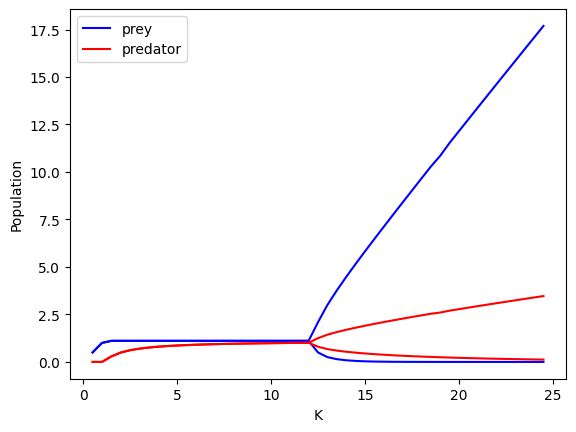

In [12]:
# print your bifurcation diagram
plt.plot(bif_k, y_max[:,0], color='blue', label='prey')
plt.plot(bif_k, y_min[:,0], color='blue')
plt.plot(bif_k, y_min[:,1], color='red')
plt.plot(bif_k, y_max[:,1], color='red', label='predator')

plt.xlabel('K')
plt.ylabel('Population')
plt.legend(loc = 'best')

### using p_tqdm

#### result = p_map(your_function, your_interable, number_of_cpus)

In this example I use the function p_map() which performs an ordered map in parallel. This means that I can keep track of the correpondence between K values and population values. You can check other functions in the [github page](https://github.com/swansonk14).



In [15]:
# first load the p_tqdm package to parallelize the simulation
from p_tqdm import p_map

# then load the cpu_count function from the os package to get the number of cores in your computer
# this will allow you to parallelize the simulation
from os import cpu_count

In [16]:
# it is necessary to create a function that receives the value of K (your iterable) and returns the max and min of both populations (your output)

def k_analysis(k_value):
    
    y = [1, 1.] # initial conditions
    time = np.arange(0, 6000, 1.) # time vector
    
    # define your parameter values
    r = 1
    a = 1.
    h = 0.1
    e = 0.1
    d = 0.1

    # create a parameter list to pass to the ODE solver in the same order as they are defined in the function of the model
    pars = (r, k_value, a, h, e, d)

    # solve the ODEs
    pops = odeint(func=RM, y0=y, t=time, args=pars)

    # store the max and min of both populations for each K value
    y_min = pops[-1000:,:].min(axis=0)
    y_max = pops[-1000:,:].max(axis=0)

    # return the max and min of both populations for each K value
    return y_max, y_min

In [17]:
# start the time stamp for the process
start = timer()

# define the range of K values you want to study
bif_k = np.arange(.5, 25, .5)

# run the simulation in parallel
results = p_map(k_analysis, bif_k, num_cpus=cpu_count()-1)
# notice I provided the function wrapping the simulation, the range of K values, 
# and the number of cores to use which is all the avaliable cores except one
# COOL TEST: try putting num_cpus=1. This will run the simulation in serial mode
# and you will notice the difference in time it takes to run the simulation

# stop the time stamp for the process
end = timer()

# return the time it took to run the simulation
print("the total time it took to complete this analysis was", end - start, "seconds")

  0%|          | 0/49 [00:00<?, ?it/s]

the total time it took to complete this analysis was 0.6515955990000748 seconds


## TA-DA!

now this is a very simple example, and the time difference between the two approches is a couple of seconds.

however, if you are studying a few parameters in your model (which is usually the reality of people working with mathematical models) you'll find it very usefull to parallelize your code AND track the progress over time.

Of course there are other ways you can parallelize your code and track progress, but what I especially like about p_tqdm is how simple and user friendly the implementation is.

In [13]:
# notice that the results are stored in a list of tuples, 
# where each tuple contains the max and min of both populations for each K value
results

[(array([ 5.0000000e-01, -2.0594491e-16]),
  array([ 5.00000000e-01, -2.17218452e-16])),
 (array([1.00000000e+00, 1.35768558e-09]),
  array([ 9.99999999e-01, -5.37276197e-10])),
 (array([1.11111111, 0.28806584]), array([1.11111111, 0.28806584])),
 (array([1.11111111, 0.49382716]), array([1.11111111, 0.49382716])),
 (array([1.11111111, 0.61728395]), array([1.11111111, 0.61728395])),
 (array([1.11111111, 0.69958848]), array([1.11111111, 0.69958848])),
 (array([1.11111111, 0.75837743]), array([1.11111111, 0.75837743])),
 (array([1.11111111, 0.80246914]), array([1.11111111, 0.80246914])),
 (array([1.11111111, 0.83676269]), array([1.11111111, 0.83676269])),
 (array([1.11111111, 0.86419753]), array([1.11111111, 0.86419753])),
 (array([1.11111111, 0.88664422]), array([1.11111111, 0.88664422])),
 (array([1.11111111, 0.90534979]), array([1.11111111, 0.90534979])),
 (array([1.11111111, 0.92117759]), array([1.11111111, 0.92117759])),
 (array([1.11111111, 0.93474427]), array([1.11111111, 0.9347442

In [18]:
# we will transform this list of tuples into a numpy array for easier manipulation
y_max_pop = []
y_min_pop = []

for r in results:
    # unpack the tuple into the max and min of both populations
    y_max, y_min = r

    # append the max and min of both populations to the respective lists
    y_max_pop.append(y_max)
    y_min_pop.append(y_min)

y_max_pop = np.array(y_max_pop)
y_min_pop = np.array(y_min_pop)

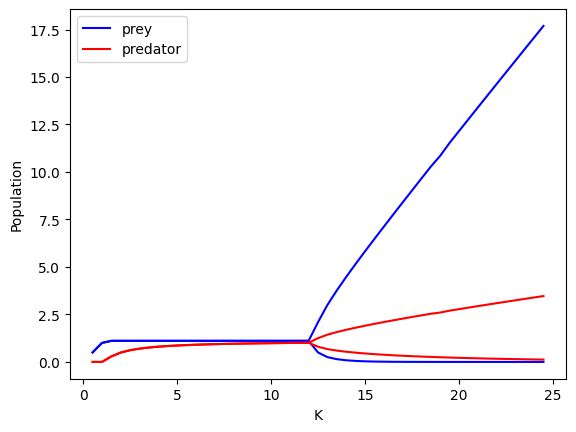

In [19]:
# print your bifurcation diagram
plt.plot(bif_k, y_max_pop[:,0], color='blue', label='prey')
plt.plot(bif_k, y_min_pop[:,0], color='blue')
plt.plot(bif_k, y_min_pop[:,1], color='red')
plt.plot(bif_k, y_max_pop[:,1], color='red', label='predator')

plt.xlabel('K')
plt.ylabel('Population')
plt.legend(loc = 'best')